# Portfolio Tracking using Quadratic Optimization
**Author:** Fatima Kasenally
**Date:** Sept 2025

---
**Abstract:**  
This notebook demonstrates how to construct a sparse portfolio that tracks the S&P 500 index using **OSQP quadratic programming**.
We start with unconstrained optimization, then add constraints, and finally apply sparsity heuristics to reduce the number of stocks in the portfolio.

In [24]:
import pandas
import osqp
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Load and Prepare Data
We import the S&P 500 index values and stock price series, then clean missing data by forward-filling the first valid value. The time series spans 15 years, from 12-Jan-2010 to 28-Apr-2025. It includes all stocks that have had membership in the SNP 500 Index during that period. This includes stocks that have joined the index after the start date, and socks which have been delisted in the interim period. As a result, the data-set contains 731 individual stocks. 

In [25]:
rawData = pandas.read_csv('Prices.csv')
print(rawData.shape)

SNPIndex = pandas.read_csv('Prices.csv', usecols=['Date', 'ES Index-A1-UnAdj on CME_USD (USD)'])
StockValues = rawData.drop(columns=['ES Index-A1-UnAdj on CME_USD (USD)'])

for col in StockValues.select_dtypes(include='number').columns:
    first_val = StockValues[col].dropna().iloc[0]
    StockValues[col] = StockValues[col].fillna(first_val)

(3848, 733)


## Compute Daily Returns
We calculate percentage changes for both the benchmark index and the stock series.

In [26]:
StockPR = StockValues.drop(columns=['Date']).pct_change().iloc[1:]
SNP_PR = SNPIndex.drop(columns=['Date']).pct_change().dropna()

Dates = pandas.read_csv('Prices.csv', usecols=['Date']).to_numpy().flatten()[1:]
Dates = pandas.to_datetime(Dates, dayfirst=True)

## Quadratic Optimization Setup
We want to find a weighting allocation $w$ to minimize the tracking error:
$$w = \underset{w}{ArgMin} \left\{||Rw - r||^2 \right\}$$
This leads to a quadratic objective: $	\frac{1}{2} w^T P w + q^T w$, with: 
- $P = 2 R^T R$
- $q = -2 R^T r$
- 
Where $R$ is our SNP 500 stock return data, and $r$ is the SNP 500 index return. 

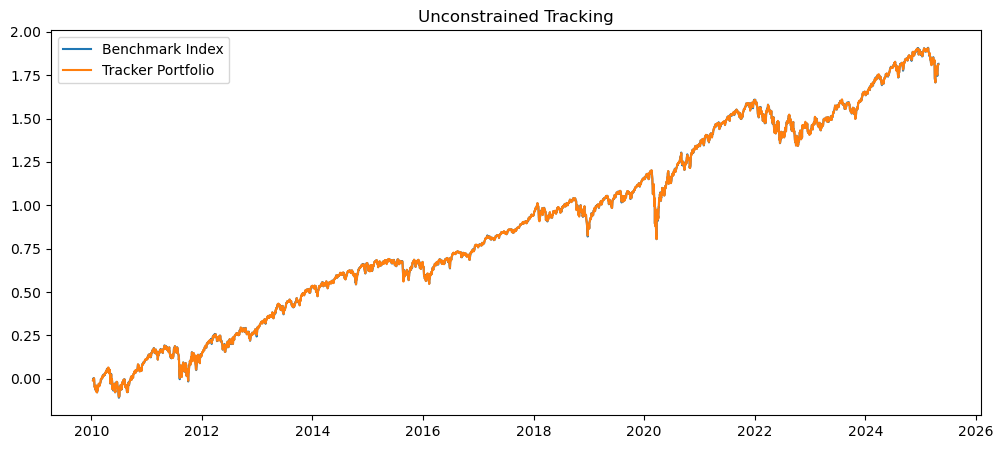

In [27]:
R = StockPR.cumsum().to_numpy()
r = SNP_PR.cumsum().to_numpy().flatten()

P = 2 * (R.T @ R)
q = -2 * (R.T @ r)
P_sparse = sparse.csc_matrix(P)

A = sparse.csc_matrix((0, R.shape[1]))
l = np.array([])
u = np.array([])

prob = osqp.OSQP()
prob.setup(P_sparse, q, A, l, u, verbose=True)
res = prob.solve()
w_opt = res.x

plt.figure(figsize=(12,5))
plt.plot(Dates, r, label='Benchmark Index')
plt.plot(Dates, R @ w_opt, label='Tracker Portfolio')
plt.title('Unconstrained Tracking')
plt.legend(); plt.show()

## Add Constraints: Sum of Weights = 1, Weights ≥ 0
This enforces a realistic long-only portfolio. Removing the ability to short any stocks. 

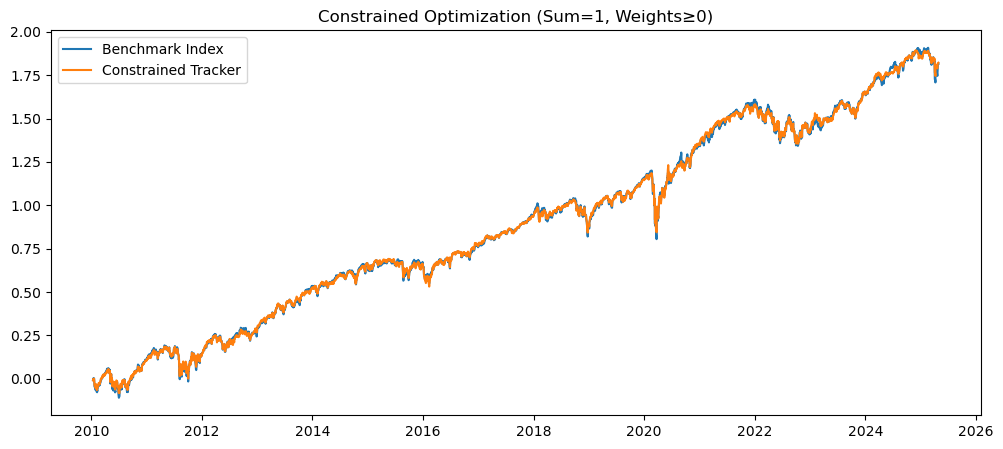

In [28]:
n = R.shape[1]
A = sparse.bmat([[np.ones((1, n))], [sparse.eye(n)]], format='csc')
l = np.hstack([1., np.zeros(n)])
u = np.hstack([1., np.ones(n)])

prob = osqp.OSQP()
prob.setup(P_sparse, q, A, l, u, verbose=True)
res = prob.solve()
w_opt = res.x

plt.figure(figsize=(12,5))
plt.plot(Dates, r, label='Benchmark Index')
plt.plot(Dates, R @ w_opt, label='Constrained Tracker')
plt.title('Constrained Optimization (Sum=1, Weights≥0)')
plt.legend(); plt.show()

## Stricter Tolerance
Using smaller solver tolerances reduces numerical drift and removes negligible weights. The default OSQP tolerace is 1e-3 which is too large for our requirements, as non-essential stocks might still be allocated upto 10BP, which incurrs potential trading costs. We therefore enforce stricter tolerances to be able to distingush between random noise and meaningful weights. 

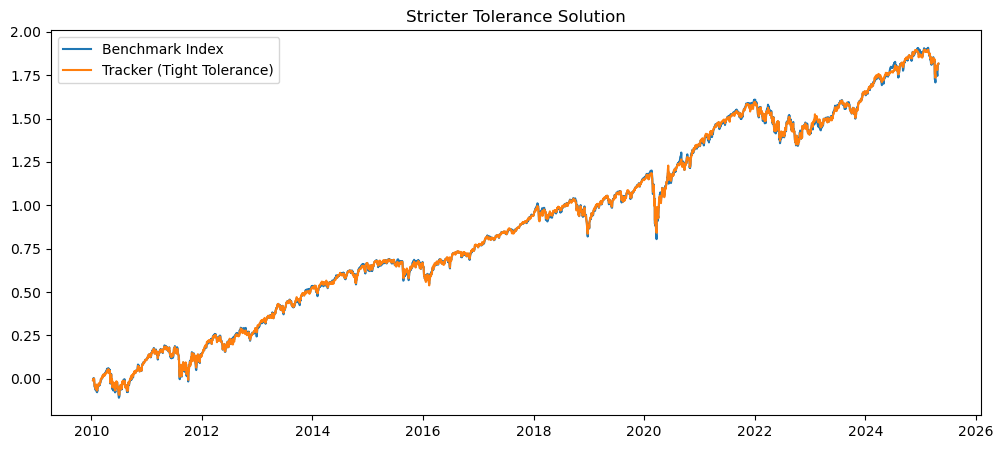

In [29]:
prob = osqp.OSQP()
prob.setup(P_sparse, q, A, l, u, verbose=True, eps_abs=1e-5, eps_rel=1e-5)
res = prob.solve()
w_opt = res.x

plt.figure(figsize=(12,5))
plt.plot(Dates, r, label='Benchmark Index')
plt.plot(Dates, R @ w_opt, label='Tracker (Tight Tolerance)')
plt.title('Stricter Tolerance Solution')
plt.legend(); plt.show()

## Sparse Tracking Heuristic
To halve the number of stocks in the portfolio, we eliminate the smallest 50% of nonzero weights and re-normalize. 
This solution is sub-optimal as the weights must be rebalanced for the smaller sub-set of stocks.

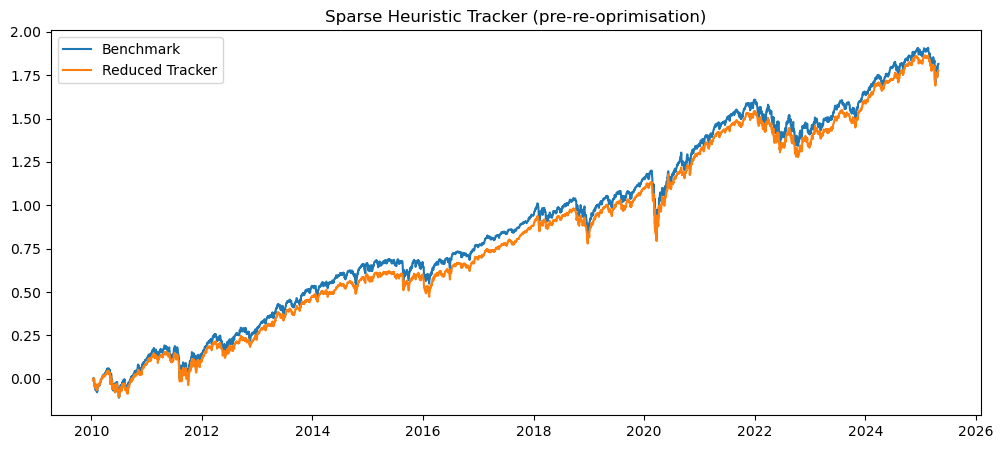

In [30]:
median_nonzero = np.median(w_opt[abs(w_opt) > 1e-5])
w_opt_dash = w_opt * (w_opt > median_nonzero)
w_opt_dash /= sum(w_opt_dash)

plt.figure(figsize=(12,5))
plt.plot(Dates, r, label='Benchmark')
plt.plot(Dates, R @ w_opt_dash, label='Reduced Tracker')
plt.title('Sparse Heuristic Tracker (pre-re-oprimisation)')
plt.legend(); plt.show()

We can see here by pruning we have removed most of the smallest weights. 

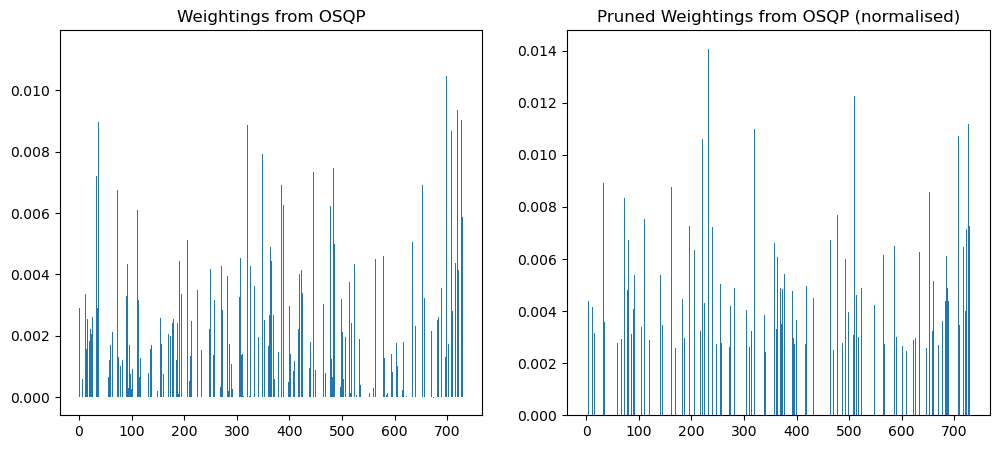

In [31]:

fig, axes = plt.subplots(1, 2, figsize=(12,5))
# UnPruned
axes[0].bar(np.arange(len(w_opt)), w_opt) 
axes[0].set_title("Weightings from OSQP")
# Pruned
axes[1].bar(np.arange(len(w_opt_dash)), w_opt_dash) 
axes[1].set_title("Pruned Weightings from OSQP (normalised)")
plt.show()


## Iterative Heuristic for Target Cardinality
We iterate pruning until the number of active stocks falls below a chosen threshold (e.g., 50). For each smaller subset of stocks, we re-optimise the weightings, then prune the 50% of active stocks with the smallest weights. 

Iteration  1 : There are  731.0  stocks in the portfolio
Iteration  2 : There are  198.0  stocks in the portfolio
Iteration  3 : There are  97.0  stocks in the portfolio
Iteration  4 : There are  48.0  stocks in the portfolio


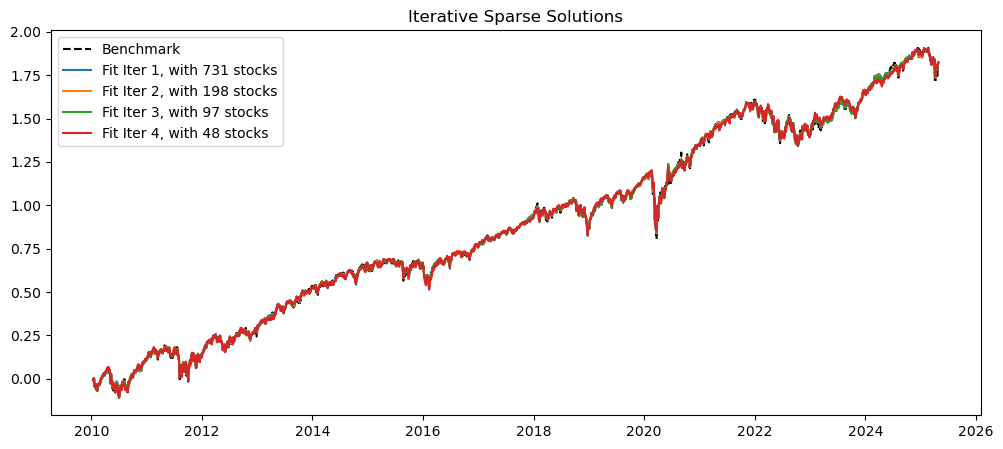

In [32]:
Number_Stocks = 50
Trading_Stocks = n
w_mask = np.ones(n)
weightings = []
cardinality = []
while Trading_Stocks > Number_Stocks:
    u = np.hstack([1., np.ones(n) * w_mask])
    Trading_Stocks = sum(w_mask)
    cardinality.append(Trading_Stocks)
    prob = osqp.OSQP()
    prob.setup(P_sparse, q, A, l, u, verbose=False, eps_abs=1e-5, eps_rel=1e-5)
    res = prob.solve()
    w_opt_i = res.x
    weightings.append(w_opt_i)
    median_w = np.median(w_opt_i[abs(w_opt_i) > 1e-5])
    w_mask = (w_opt_i > median_w).astype(float)
    print("Iteration ", len(weightings),": There are ",Trading_Stocks," stocks in the portfolio")

plt.figure(figsize=(12,5))
plt.plot(Dates, r, label='Benchmark', color='black', linestyle='--')
for i, w in enumerate(weightings):
    plt.plot(Dates, R @ w, label=f"Fit Iter {i+1}, with {int(cardinality[i])} stocks")
plt.title('Iterative Sparse Solutions')
plt.legend(); plt.show()

In the next plot, we see how the weight allocations change across iterations for the stocks reported in the terminal solution. 

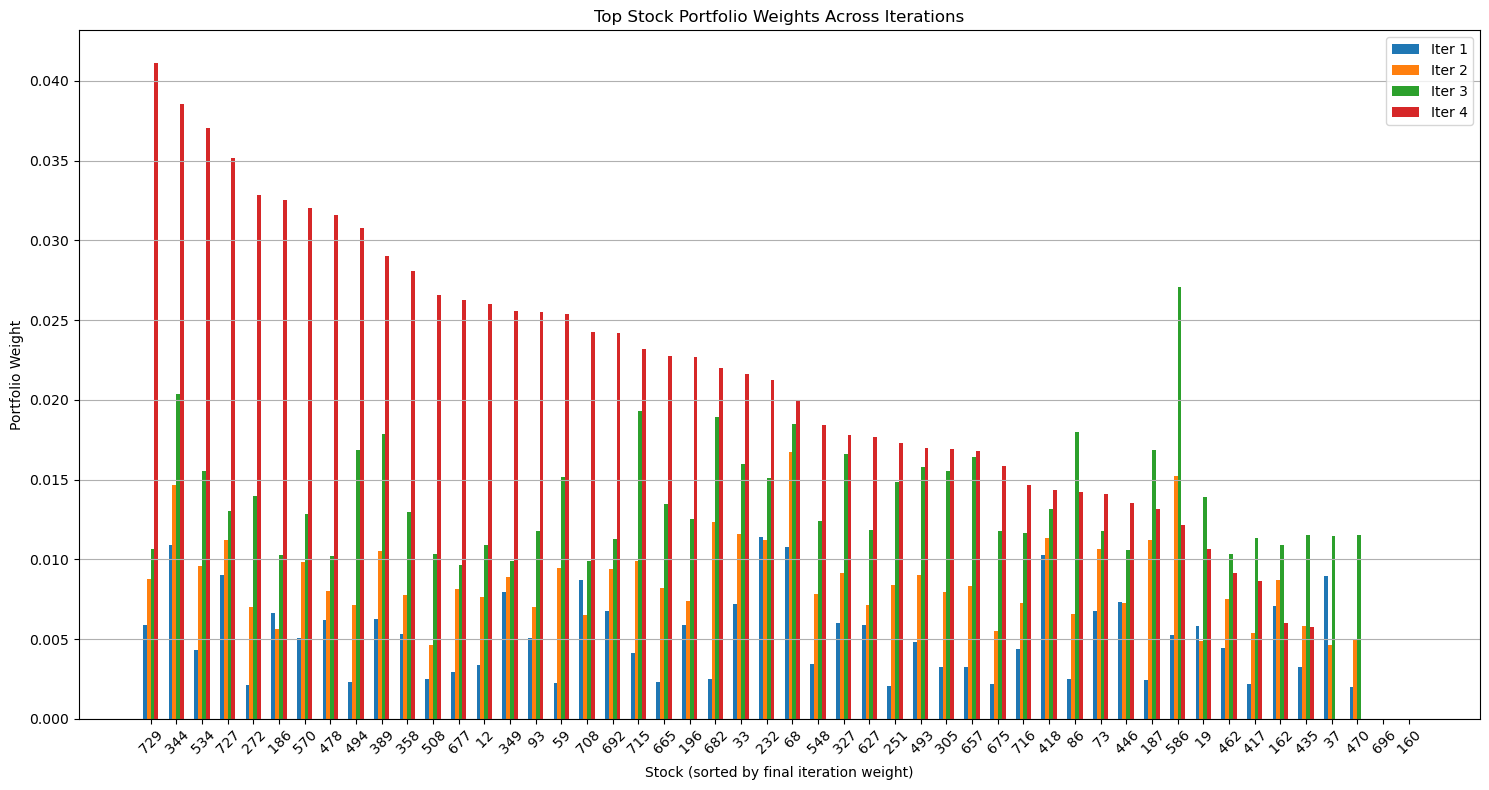

In [33]:

W = np.vstack(weightings)  # shape (n_iter, n_stocks)
sorted_indices = np.argsort(-W[-1])  # descending order based on last iteration
top_n = 50
top_indices = sorted_indices[:top_n]
top_weights = W[:, top_indices]  # shape: (n_iter, top_n)

bar_width = 0.15
x = np.arange(top_n)  # one group per stock

plt.figure(figsize=(15, 8))

for i in range(len(weightings)):
    offset = i * bar_width
    plt.bar(x + offset, top_weights[i], width=bar_width, label=f'Iter {i+1}')

plt.xlabel("Stock (sorted by final iteration weight)")
plt.ylabel("Portfolio Weight")
plt.title("Top Stock Portfolio Weights Across Iterations")
plt.xticks(x + bar_width * (len(weightings) - 1) / 2, [f" {i}" for i in top_indices], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

## Tracking Error
The following plots display the tracking error from each iteration of the method. 

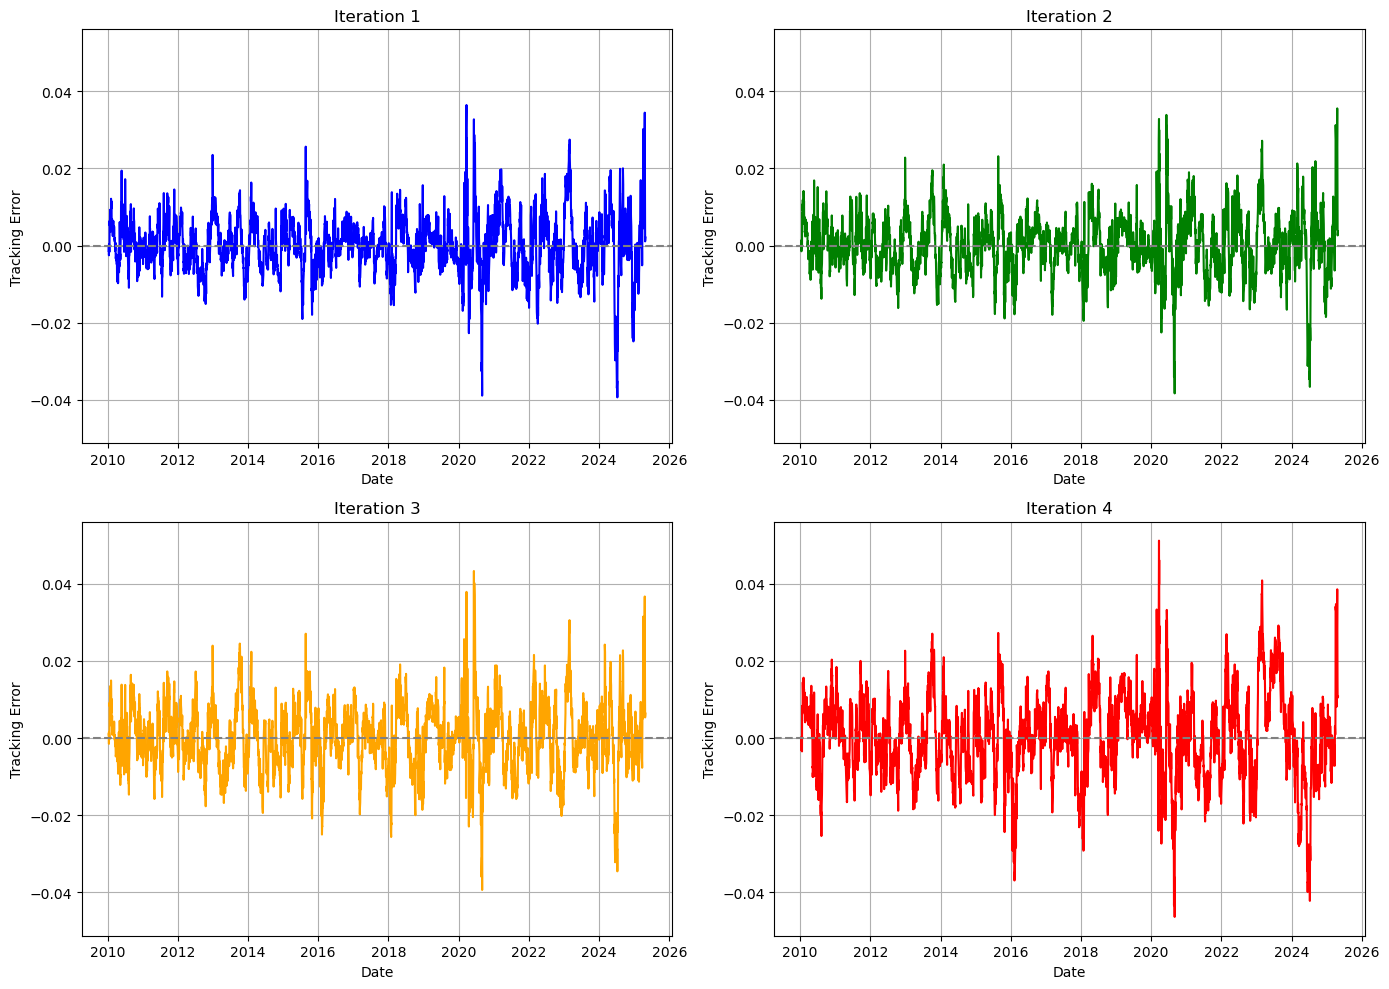

In [34]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Flatten axes for easy looping
axes = axes.flatten()

colors = ['blue', 'green', 'orange', 'red']

for i, ax in enumerate(axes):
    ax.plot(Dates, (R @ weightings[i]) - r, color=colors[i])
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title(f"Iteration {i+1}")   # iteration numbering
    ax.set_xlabel("Date")
    ax.set_ylabel("Tracking Error")
    ax.grid(True)
    ax.tick_params(axis='both', which='both')  # ensures scales (ticks) are drawn
    ax.tick_params(labelbottom=True, labelleft=True)

plt.tight_layout()
plt.show()


In [35]:
for i, w in enumerate(weightings, start=1):
    tracking_error = (R @ w) - r
    mse = np.mean(tracking_error**2)
    print(f"Iteration {i}:")
    print(f"  MSE = {mse:.6f}")

Iteration 1:
  MSE = 0.000055
Iteration 2:
  MSE = 0.000058
Iteration 3:
  MSE = 0.000075
Iteration 4:
  MSE = 0.000120


We see as our solution becomes more sparse, our MSE of the tracking error increases. 

### Summary of Iterative Weighting Plots

The 2x2 grid of the top 200 weights across the first four iterations clearly shows the effects of the iterative sparsity heuristic. 

As iterations progress, the maximum weight assigned to individual stocks gradually increases, reflecting the reallocation of weight from eliminated smaller stocks. At the same time, the number of stocks carrying significant weight decreases, resulting in a horizontal compression of the distribution. Despite this reduction in the number of active stocks, the total allocation remains normalized to 1, which explains why the remaining bars grow slightly taller in each successive iteration. Overall, the plots visually demonstrate how the iterative method concentrates allocation on the most influential stocks, effectively reducing portfolio complexity while still maintaining strong tracking performance of the benchmark index.


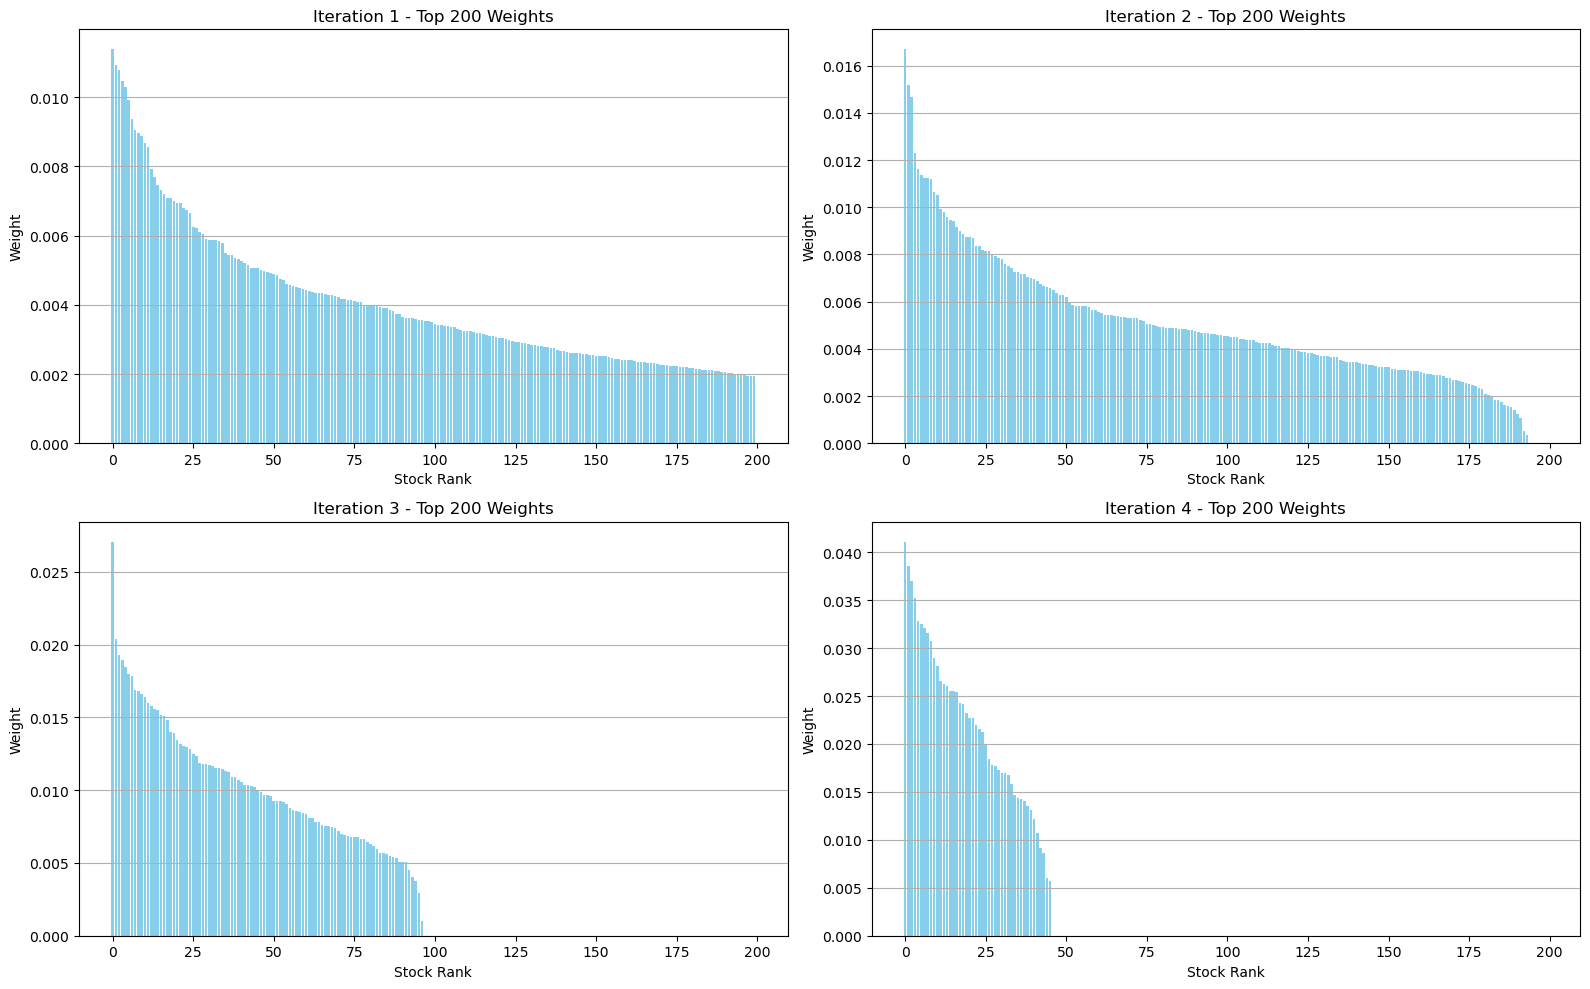

In [36]:
top_n = 200  # show top 20 weights
iterations_to_plot = 4  # first 4 iterations

fig, axes = plt.subplots(2, 2, figsize=(16,10))
axes = axes.flatten()  # easier indexing

for i in range(iterations_to_plot):
    w = weightings[i]
    # get indices of top_n weights
    top_indices = np.argsort(-w)[:top_n]
    top_weights = w[top_indices]
    
    axes[i].bar(np.arange(top_n), top_weights, color='skyblue')
    axes[i].set_title(f'Iteration {i+1} - Top {top_n} Weights')
    axes[i].set_xlabel('Stock Rank')
    axes[i].set_ylabel('Weight')
    axes[i].grid(True, axis='y')

plt.tight_layout()
plt.show()


## Terminal Tracking Solution

Now we report the final weight allocations to the selected subset of SNP 500 stock that optimally track the full SNP 500 index. 

In [37]:
StockPR.columns = StockPR.columns.str.replace("_US_USD_USD", "", regex=False)
stock_names = StockPR.columns.to_numpy()

final_weights = weightings[-1]  

portfolio = pandas.DataFrame({
    "SNP 500 Stock": stock_names,
    "Weight": final_weights
})

portfolio = portfolio[portfolio["Weight"] > 1e-6]
portfolio = portfolio.sort_values(by="Weight", ascending=False)

print(portfolio)

          SNP 500 Stock    Weight
729      VLTO US Equity  0.041109
344      NVDA US Equity  0.038526
534       RCL US Equity  0.037027
727        SW US Equity  0.035193
272       KMI US Equity  0.032857
186       ETR US Equity  0.032526
570        UA US Equity  0.032051
478       WFC US Equity  0.031595
494       XRX US Equity  0.030787
389       RDC US Equity  0.029007
358       PCL US Equity  0.028107
508       GGP US Equity  0.026589
677       OGN US Equity  0.026266
12   1683997D US Equity  0.026039
349      ORCL US Equity  0.025573
93        BMC US Equity  0.025491
59       AMZN US Equity  0.025380
708      INVH US Equity  0.024282
692      MTCH US Equity  0.024204
715      BLDR US Equity  0.023215
665       TYL US Equity  0.022746
196        FE US Equity  0.022658
682      TSLA US Equity  0.021984
33       AAPL US Equity  0.021591
232      HCBK US Equity  0.021222
68       APOL US Equity  0.019971
548      CPGX US Equity  0.018399
327       NBL US Equity  0.017788
627      ANET 

As seen, here our final portfolio includes some de-listed stocks. To resolve this, simply remove the delisted stocks from the original data set. 